In [43]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)
from collections import OrderedDict, Counter
from itertools import product
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
sns.set(font_scale=1)
sns.set_style("white")
sns.set_style("ticks")
import os
import sys
sys.path.insert(0, '../../src')
from utils import ProcessData
from starlette.config import Config

import unicodedata
from tqdm import tqdm
import re
import io
import msoffcrypto

from googletrans import Translator

translator = Translator()
config = Config("../../../../../.env")
pw = config("HASEKO_DATA_PW", cast=str)

%matplotlib inline

In [44]:
def get_boundaries(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def remove_outliers(df, column):
    lower_bound, upper_bound = get_boundaries(df, column)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# New training data

In [45]:
area = {'1100': 'Saitama',
        '1200': 'Chiba',
        '1301': 'Central Tokyo',
        '1302': 'Western Tokyo',
        '1303': 'Eastern Tokyo',
        '1304': 'Tokyo city',
        '1400': 'Kanagawa'}

new_dict = ['年齢\nage','合算後年収.1\nAnnual income after the sum .1','合算後年収\nAnnual income after the sum', '家族数\nFamily number',
            '家族F\nFamily F','物件価格(千円)\nProperty price (1,000 yen)', '面積\narea','LP名\nLP name',
            '最新住所\nLatest address']

In [46]:
data_dir = '../../haseko_v1_data_analysis/data/コピーデータ240215_4回目.xls'
unlocked_file = io.BytesIO()

excel_file = msoffcrypto.OfficeFile(open(data_dir, "rb"))
excel_file.load_key(password = pw)
excel_file.decrypt(unlocked_file)
df = pd.read_excel(unlocked_file)

df.columns = [unicodedata.normalize('NFKC', s) for s in df.columns]
df.columns = [s+'\n'+str(translator.translate(s, dest='en').text) for s in df.columns]
df['物件価格(千円)\nProperty price (1,000 yen)'] /= 10

# Select relevant columns
df = df[new_dict]
# Remove outlier
df = remove_outliers(df, '面積\narea')
# Remove possible pair loan
col = ['家族数\nFamily number','家族F\nFamily F','物件価格(千円)\nProperty price (1,000 yen)','面積\narea','LP名\nLP name','最新住所\nLatest address']
dup = df[df.duplicated(subset=col, keep=False)]
df = df.loc[[i for i in df.index if i not in dup.index],:]

print(df.shape)
df.head()

(3740, 9)


,年齢\nage,合算後年収.1\nAnnual income after the sum .1,合算後年収\nAnnual income after the sum,家族数\nFamily number,家族F\nFamily F,"物件価格(千円)\nProperty price (1,000 yen)",面積\narea,LP名\nLP name,最新住所\nLatest address
2,36,8,～800万円,2,DINKS,3298.0,35.73,今回追加したデータ,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前
3,48,4,～400万円,1,独身,3378.0,35.73,今回追加したデータ,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前
4,42,4,～500万円,1,独身,3598.0,35.73,今回追加したデータ,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前
5,29,4,～500万円,3,独身,2588.0,30.72,今回追加したデータ,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前
6,51,4,～400万円,1,独身,3448.0,35.73,今回追加したデータ,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前


In [47]:
dup.head()

,年齢\nage,合算後年収.1\nAnnual income after the sum .1,合算後年収\nAnnual income after the sum,家族数\nFamily number,家族F\nFamily F,"物件価格(千円)\nProperty price (1,000 yen)",面積\narea,LP名\nLP name,最新住所\nLatest address
0,35,10,～1000万円,3,ファミリー,4800.0,65.01,マンション中心のLPの案件,さいたま市浦和区 上木崎 １－２－２４ クラッシィハウス浦和上木崎
1,34,10,～1000万円,3,ファミリー,4800.0,65.01,マンション中心のLPの案件,さいたま市浦和区 上木崎 １－２－２４ クラッシィハウス浦和上木崎
10,35,9,～1000万円,2,DINKS,7032.0,64.45,マンション中心のLPの案件,さいたま市浦和区 仲町 １－９－１０ Brillia浦和仲町
11,32,9,～1000万円,2,DINKS,7032.0,64.45,マンション中心のLPの案件,さいたま市浦和区 仲町 １－９－１０ Brillia浦和仲町
22,31,7,～700万円,2,DINKS,4058.0,65.94,今回追加したデータ,稲城市 大丸 ２２１６－１ ミオカステーロ南多摩


# Previous training data

In [58]:
pws_dict = {'age':'年齢\nage',
            'income':'合算後年収.1\nAnnual income after the sum .1',
            # 'income bin':'合算後年収\nAnnual income after the sum',
            'family_members':'家族数\nFamily number',
            'mf_family_type_str':'家族F\nFamily F',
            'price':'物件価格(千円)\nProperty price (1,000 yen)',
            'width':'面積\narea',
            'name':'LP名\nLP name',
            'pref_code':'pref_code',
            'pref_name':'pref_name',
            'city_code':'city_code',
            'city_name':'city_name',
            'area_code':'area_code',
            'area_name':'area_name',
            'search_area_code':'search_area_code',
            'search_area_name':'search_area_name',
            'lon':'lon',
            'lat':'lat'}

col = ['年齢\nage','家族F\nFamily F','物件価格(千円)\nProperty price (1,000 yen)']
match_family_type = {'DINKS':'パートナー','ファミリー':'パートナーと子供','自分ひとり':'独身'}

In [59]:
base_params = '../../src/params'
base_data = '../../haseko_v0/data/mansionfit_2020-12-02.csv'

data = ProcessData()
params_ml, _, area_data = data.load_json_file(base_params)
pws_previous, _, _ = data.create_user_buildings_df(base_data, area_data)
pws_previous = pws_previous.dropna(axis=0)
pws_previous['family_members'] = pws_previous['family_members'].astype(int)
pws_previous['income'] /= 1000000
pws_previous['price'] /= 10000
pws_previous = pws_previous[pws_dict.keys()]
pws_previous.columns = pws_dict.values()
pws_previous['家族F\nFamily F'] = [match_family_type[i] if i in match_family_type.keys() else i for i in pws_previous['家族F\nFamily F']]
print(pws_previous.shape)
# col = ['家族数\nFamily number','家族F\nFamily F','物件価格(千円)\nProperty price (1,000 yen)','面積\narea','LP名\nLP name','pref_code','pref_name','city_code','city_name','area_code','area_name','search_area_code','search_area_name','lon','lat']
# pws_previous = pws_previous.drop_duplicates(subset=col, keep=False, inplace=False)

# print(pws_previous.shape)
pws_previous.head(1)

(5487, 17)


,年齢\nage,合算後年収.1\nAnnual income after the sum .1,家族数\nFamily number,家族F\nFamily F,"物件価格(千円)\nProperty price (1,000 yen)",面積\narea,LP名\nLP name,pref_code,pref_name,city_code,city_name,area_code,area_name,search_area_code,search_area_name,lon,lat
0,53.0,15.0,5,パートナーと子供,5589.91,70.56,ザ・ガーデンズ東京王子,13,東京都,13117,北区,1303,東京東部,1303,東京23区東エリア,139.726858,35.763803


In [60]:
base_params = '../../src/params'
base_data = '../../haseko_v0/data/mansionfit_20240312_013333.csv'

data = ProcessData()
params_ml, _, area_data = data.load_json_file(base_params)
pws_new, _, _ = data.create_user_buildings_df(base_data, area_data)
pws_new = pws_new.dropna(axis=0)
pws_new['family_members'] = pws_new['family_members'].astype(int)
pws_new['income'] /= 1000000
pws_new['price'] /= 10000
pws_new = pws_new[pws_dict.keys()]
pws_new.columns = pws_dict.values()

print(pws_new.shape)
# col = ['家族数\nFamily number','家族F\nFamily F','物件価格(千円)\nProperty price (1,000 yen)','面積\narea','LP名\nLP name','pref_code','pref_name','city_code','city_name','area_code','area_name','search_area_code','search_area_name','lon','lat']
# pws_new = pws_new.drop_duplicates(subset=col, keep=False, inplace=False)

# print(pws_new.shape)
pws_new.head(1)

(10473, 17)


,年齢\nage,合算後年収.1\nAnnual income after the sum .1,家族数\nFamily number,家族F\nFamily F,"物件価格(千円)\nProperty price (1,000 yen)",面積\narea,LP名\nLP name,pref_code,pref_name,city_code,city_name,area_code,area_name,search_area_code,search_area_name,lon,lat
0,53.0,15.0,5,パートナーと子供,5589.91,70.56,ザ・ガーデンズ東京王子,13,東京都,13117,北区,1303,東京東部,1303,東京23区東エリア,139.726858,35.763803


In [61]:
duplicates = pd.merge(pws_new, pws_previous, how='inner')
print(len(duplicates))

5089


In [62]:
duplicates = pd.merge(df[col], pws_previous[col], how='inner')
print(len(duplicates))

20


In [63]:
duplicates = pd.merge(df[col], pws_previous[col], how='inner')
print(len(duplicates))

20


# Data aggregation

In [41]:
data = pd.concat([df, pws_new],axis=0).rename(columns={'物件価格(千円)\nProperty price (1,000 yen)':'物件価格(万円)\nProperty price (10,000 yen)'})
data['家族F\nFamily F'] = [match_family_type[i] if i in match_family_type.keys() else i for i in data['家族F\nFamily F']]
data['salary@65'] = [max(0, (65 - age) * salary * 0.02) for age, salary in zip(data['年齢\nage'], data['合算後年収.1\nAnnual income after the sum .1'])]
data['kids_expenses'] = [max(0, (i-2)*100000*12) for i in data['家族数\nFamily number']]
data['estimated_savings'] = [max(0, (age - 25) * salary * 0.06) if status == '独身' else (age - 25) * salary * 0.03 if status == 'パートナー' else (age - 25) * salary * 0.01 for status, age, salary in zip(data['家族F\nFamily F'], data['年齢\nage'], data['合算後年収.1\nAnnual income after the sum .1'])]
data = data.drop_duplicates(keep=False, inplace=False)
data = data.reset_index(drop=True)

print(data.shape)
data.head(1)

(14207, 22)


,年齢\nage,合算後年収.1\nAnnual income after the sum .1,合算後年収\nAnnual income after the sum,家族数\nFamily number,家族F\nFamily F,"物件価格(万円)\nProperty price (10,000 yen)",面積\narea,LP名\nLP name,最新住所\nLatest address,pref_code,pref_name,city_code,city_name,area_code,area_name,search_area_code,search_area_name,lon,lat,salary@65,kids_expenses,estimated_savings
0,36.0,8.0,～800万円,2,パートナー,3298.0,35.73,今回追加したデータ,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.64,0,2.64


# Data visualization

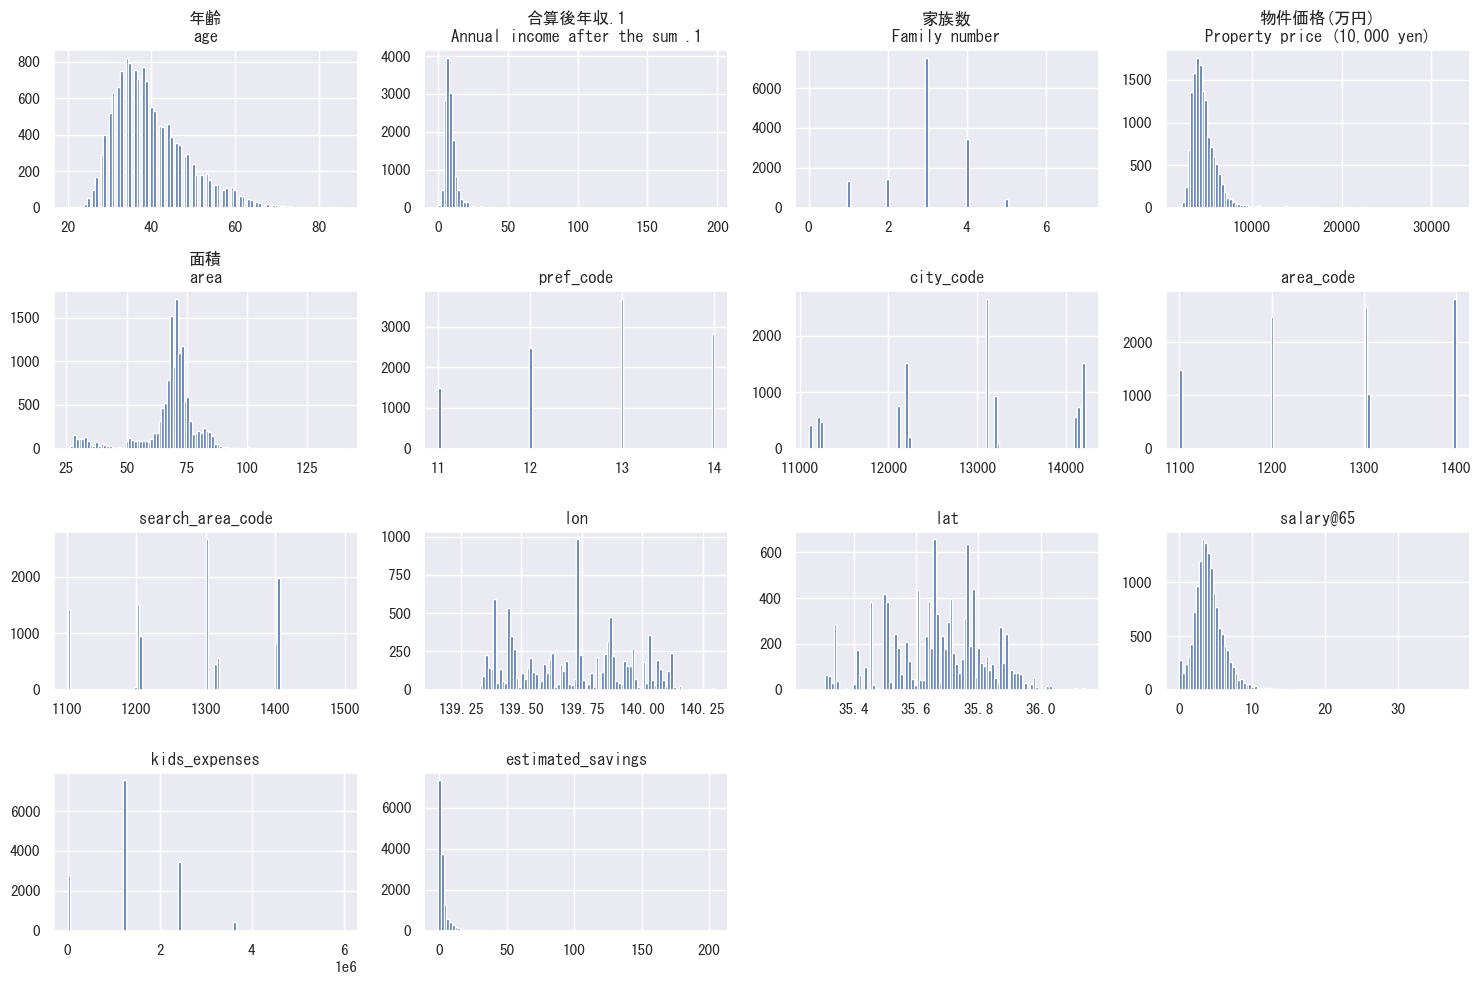

In [42]:
sns.set(font_scale=1.0, font="MS Gothic")
data.hist(bins=100, figsize=(15, 10))
plt.tight_layout()
plt.show()